# <span style="color:#336699">Introduction to Data Science - CAP 394 [<img src="./img/icone_cap394.svg" alt="CAP394 - Introduction to Data Science" style="height:120px;" align="right">](http://www.lac.inpe.br/~rafael.santos/cap394.html)</span>


<hr style="border:2px solid #0077b9;">

   
<h1> <p align="right"> Exploratory Analysis of Meteorological Radar Dataset </p> </h1>
   
<p align='center'> Project for course  Introduction to Data Science - CAP 394</p>

#### Instructors: 
* Dr. Gilberto Queiroz 
* Dr. Rafael Santos

#### Student: 
* Helvecio Leal Neto



## Schedule
     - [x] Data reading
     - [x] Data visualization
     - [x] Preprocessing
     - [x] Cluster detection algorithm
     - [x] Relational Directions
     - [x] Create Data Functions
     - [x] Visualization Radar image
     - [x] Statistics and Results
     - [ ] Final analysis and project elaboration

### Index

  [About](#about) <br></br>
  [The Data](#the_data)<br></br>
  [Reading Data](#reading_data)<br></br>
  
 <hr style="border:1px solid #0077b9;">

<a id='about'></a>
## About

<p align="justify"> <br>
This work is part of the suite of applications for the Introduction to Data Science (CAP-394) course offered by the National Institute for Space Research.

The purpose of this paper is to perform an exploratory analysis of radar data, gathering raw data, processing it and understanding the dynamics of cloud location from its center of mass, as well as counting the number of clusters per period.
At the end of the exploratory process it will be possible to estimate the behavior of the clouds and relate their geographical location as well as correlate average precipitation rates per hour.

<hr style="border:1px solid #0077b9;">

<a id='the_data'></a>
## The Data

<p align="justify"><br>
The data analyzed in this example consists of NC (NetCDF4) files. Each file corresponds to Rain Rate measurements collected by the Amazon Protection System (SIPAM) radar during the GoAmazon experiment periods, starting from January 2014 to December 2015, such files contain data on 12-minute time intervals. The dataset provides rain data over 2.5km from S-Band Radar located in lat: -3.148556, lon: -59.992000. Data dimensionality consists of a two-dimensional (241x241) matrix containing rain rate values, the Radar Radius range is approximately 240 km, covering an area of 1,500 km² over the state of Amazonas (Brazil).
<p align="justify"><br>
Overview:

"S-band radar volumes from Manaus, Brazil were shared by SIPAM for the time period beginning in January 2014 to December 2015 partially coinciding with the GOAmazon field campaign. The corrected radar reflectivity from each volume were interpolated to a fixed grid and the rainfall products were generated. A single Z-R relation (Z=174.8R^1.56) was created using 2014 wet-season impact disdrometer data and applied to the 2.5 km SIPAM Manaus S-Band CAPPI data to generate rain rates for each radar volume. This is version 2.0a of the dataset, which benefits from improved quality control procedures to remove non-meteorological data. " Schumacher</p>


https://www.arm.gov/research/campaigns/amf2014goamazon <br>

* Courtney Schumacher	S-band Radar - Rain Rates

<img src="img/SIPAM.png" align="center" alt="Drawing" style="width: 600px;">


[Figure 01: REDEMET - Radar Manaus](https://www.redemet.aer.mil.br/?i=produtos&p=radares-meteorologicos)
<hr style="border:1px solid #0077b9;">

## Questions about the data

1. How can I do the data acquisition?
2. How can I open the data?
3. What are the functions to view the data content?
4. How to format data efficiently?
5. Which precipitation rate intensity thresholds are interesting?
6. What techniques for clustering can be applied to the dataset?
7. How to convert values in Rain Rate Fall to DBz?
8. What geographic applications can be associated with data?
9. How to organize and process data efficiently?
10. How to use a library to plot radar images?
11. How many clusters per hour and month are in the dataset?
12. What is the accumulated rain fall present in the data?
13. What are the directional relationships of each cluster?

<hr style="border:1px solid #0077b9;">

<a id='reading_data'></a>
## 1. Basic read process

### 1.1 Reading the metadata file

In [1]:
import os
import xarray as xr

In [2]:
### open files day 2014 / 01 / 03
day = 20150315

### path contains dataset
path = 'data/radar/'

#read first file to extract static variable values
first_file = path+str(day)+'/'+str(os.listdir(path+str(day))[0])
    
try:
    xds = xr.open_dataset(first_file)   
except Exception as e:
    print('File not found')
xds

<xarray.Dataset>
Dimensions:     (x0: 241, y0: 241)
Dimensions without coordinates: x0, y0
Data variables:
    start_time  datetime64[ns] ...
    stop_time   datetime64[ns] ...
    lat0        (y0, x0) float32 ...
    lon0        (y0, x0) float32 ...
    rain_rate   (y0, x0) float32 ...
Attributes:
    description:  SIPAM Manaus S-Band Gridded Rain Rates
    source:       SIPAM Manaus S-Band Radar
    institution:  SIPAM/Texas A&M University
    comment:      v2.0a; Created at Texas A&M University (cschu@tamu.edu)
    references:   http://atmo.tamu.edu/goamazon-sband-radar
    created:      Wed Sep  6 19:51:30 2017\n

In [3]:
# settingup the variables
rr = xds.rain_rate                  ### Matrix with preciptation values
runit = xds.rain_rate.units         ### Unit of rain_rate mm/h
rkm = xds.rain_rate.height_km       ### Unit of matrix dimensions km
lon = xds.lon0.data                 ### Coordinate Longitude Matrix
lat = xds.lat0.data                 ### Corrdinate Latitude Matrix
x0 = xds.x0                         ### Matrix of points
y0 = xds.y0

print('Unit of Rain Rate: ',runit)

Unit of Rain Rate:  mm/hr


### 1.2 Read data function

In [4]:
import numpy as np

def readData(date):
    
    path = 'data/radar/'
    dataset = []
    interval = len(os.listdir(path+str(date)))    
    
    # Original grid dimensions
    nx = 241
    ny = 241

    # Define container
    frames = np.zeros( (interval, nx, ny ) )    
    
    for i in range(interval):
        d = str(path)+str(date)+'/'
        file = (sorted(os.listdir(path+str(date)))[i])
        xds = xr.open_dataset(d+file)
        rr = xds.rain_rate
        frames[i] =  rr
            
    return frames

#### The values loaded for frames correspond to the number of daily observations, and their respective matrices with rainfall rate values.

In [5]:
frames = readData(day)
print('The frames from dataset:data (times,x,y) -> ',frames.shape)

The frames from dataset:data (times,x,y) ->  (3, 241, 241)


#### Plot simple example for visualization

In [6]:
import matplotlib.pyplot as plt
## Plot simple figure from dataset

day = 20150315

figtime = 0
filename = sorted(os.listdir(path+str(day)))[figtime]

plt.figure(figsize=(8,4))
plt.title(filename)
plt.scatter(lon,lat,frames[figtime])
plt.show();

<Figure size 800x400 with 1 Axes>

### 1.3 Pre-Processing Function

This function is used to store matrix "x" and "y" coordinates, that have values diffent than "NaN" and greater than the fixed Threshold for each cloud, the values correspond to the characteristic threshold intensity of each point.

<img src="img/dbz_scale.png" align="center" alt="Drawing" style="width: 800px;">

In [7]:
import pandas as pd

def pre_processing(time1):
    np.warnings.filterwarnings('ignore')
    
    ## thereshold value to track
    threshold = 21.8
    
    rs =  (np.where(time1 != np.nan) and np.where(time1 > threshold))
    rs = np.asanyarray(rs)
    pe = pd.DataFrame({'x1':rs[0],'y1':rs[1]})
        
    return pe

In [8]:
pdata = pre_processing(frames[0])
pdata.head()

,x1,y1
0,29,153
1,61,93
2,65,85
3,68,83
4,68,85


Pre_processing function output with values "x" and "y".

### 1.4 Clustering Process with MeanShift

The purpose of the Mean-Shift clustering technique is to infer the average of clusters by their related density function, where an area calculation is made where the density values are higher and at this point a central point called centroid is measured. The process is performed recursively and is only terminated when the inference value is equal to the previous one.

<img src="img/ms_2d_bw_2.gif" align="left" alt="Drawing" style="width: 400px;">

In [11]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def clust(time1):
    
    te = time1
    
    if len(te) < 20:
        return None

    bandwidth = estimate_bandwidth(te, quantile=0.3, n_samples=None, random_state=0, n_jobs=None)
    
    if bandwidth > 0:
        ms = MeanShift(bandwidth=5, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)
    else:
        ms = MeanShift(bandwidth=10, bin_seeding=None, cluster_all=True, min_bin_freq=1,
    n_jobs=None, seeds=None)

    ms.fit(te)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_clusters_ = len(np.unique(labels))
    te['cluster']=labels
        
#     colors = 10*['r.','g.','b.','c.','k.','y.','m.']
#     for i in range(len(te)):
#         plt.plot(te['x1'][i], te['y1'][i], colors[labels[i]], markersize = 10)
#         plt.title('Estimated number of clusters: %d' % n_clusters_)
        
#     for i, txt in enumerate(range(n_clusters_)):
#         plt.annotate(txt,(cluster_centers[i,0],cluster_centers[i,1]),textcoords="offset points",xytext=(0,10),ha='center')
#     te['cluster']=labels
    
#     plt.scatter(cluster_centers[:,0], cluster_centers[:,1],
#                marker = 'x', s=150, linewidths=10, zorder=10)
    
    return te

,x1,y1,cluster
0,29,153,9
1,61,93,8
2,65,85,6
3,68,83,6
4,68,85,6


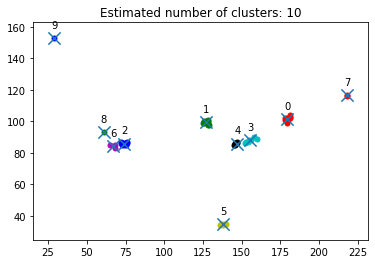

In [10]:
day = 20150315
frames = readData(day)
pdata = pre_processing(frames[0])
clusters = clust(pdata)
clusters.head()

### 1.5 Direction Relations

To define direction relationships between the central points of each cloud and the radar, we use the directional relationship between the points. This approach has as its principle to relate the coordinates of the points and to verify the location between a reference point and a point to be measured. According (Papadias & Sellis, 1994), there are nine possible ways to place a primary point relative to a reference point in the plane, and thus nine disjoint relationships between coordinate pairs that provide complete object coverage.

<img src="img/direction_relations.png" align="center" alt="Drawing" style="width: 800px;">

In [12]:
def tRelation(p,q):

    north_west       =  p[1] <  q[1] and  p[0] >  q[0] 
    restricted_north =  p[1] == q[1] and  p[0] >  q[0]
    north_east       =  p[1] >  q[1] and  p[0] >  q[0]
    restricted_west  =  p[1] <  q[1] and  p[0] == q[0]
    same_position    =  p[1] == q[1] and  p[0] == q[0]
    restricted_east  =  p[1] >  q[1] and  p[0] == q[0]
    south_west       =  p[1] <  q[1] and  p[0] <  q[0]
    restricted_south =  p[1] == q[1] and  p[0] <  q[0] 
    south_est        =  p[1] >  q[1] and  p[0] <  q[0]

    if north_west == True:
        return ('NW')
    if restricted_north == True:
        return ('RN')
    if north_east == True:
        return ('NE')
    if restricted_west == True:
        return ('RW')
    if same_position == True:
        return('SP')
    if restricted_east == True:
        return ('RE')
    if south_west == True:
        return ('SW')
    if restricted_south == True:
        return ('RS')
    if south_est == True:
        return ('SE')

In [13]:
x1,y1 = -1.9451030492782593,-61.034568786621094      # p(POINT)
r1,r2 = -3.148556, -59.992000                        # q(RADAR)
p = (x1,y1)                                    #PONTO
q = (r1,r2)                                    #RADAR

print('Point p is ',tRelation(p,q),' of the radar.')

Point p is  NW  of the radar.


### 1.6 Create Data Process

In [14]:
from geopy.distance import geodesic

def createData(day,time,clusters,frames):
    
    ##Static Radar Coordinates Value for Topological relation
    radar = (-3.148556, -59.992000)

    if isinstance(clusters,pd.DataFrame):

        FAM1 = pd.DataFrame(columns=['DATETIME',
                                     'N_Cluster','ID_CLUS','LAT','LON','DIST','IND_X','IND_Y',
                                     'T_RELATION','RAIN_FALL','DBz'])
        
        rfall = []
        rlation = []
        ddist = []

        LAT_ = (lat[clusters['x1'],clusters['y1']])
        LON_ = (lon[clusters['x1'],clusters['y1']])
        
        # Calculate distance
        for i, row in clusters.iterrows():
            pt =(str(LAT_[i])+','+str(LON_[i]))
            d = (geodesic(radar, pt).kilometers)
            ddist.append(d)

        # Calculate relation
        for i,row in clusters.iterrows():
            rfall.append(frames[row['x1']][row['y1']])
            r = tRelation((LAT_[i],LON_[i]),radar)
            rlation.append(r)
            
        xds = xr.open_dataset(str(path)+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[time]))
        dtime = xds.start_time.values
        
        FAM1['IND_X'], FAM1['IND_Y'] = clusters['x1'].astype('int16'),clusters['y1'].astype('int16')
        FAM1['LAT'],FAM1['LON'] = LAT_,LON_
        FAM1['DIST'] = ddist
        FAM1['N_Cluster'] = len(clusters['cluster'].unique())
        FAM1['ID_CLUS'] = clusters['cluster']
        FAM1['RAIN_FALL'] = rfall
        FAM1['T_RELATION'] = rlation
        FAM1['DBz'] =  10 * np.log10(200*FAM1['RAIN_FALL']**1.6)
        FAM1['DATETIME'] = pd.to_datetime(dtime)
        FAM1 = FAM1.set_index('DATETIME')
        FAM1 = FAM1.sort_values('ID_CLUS')
        
    else:
        return None

    return FAM1

In [15]:
day = 20150315
time = 0
frames = readData(day)
pdata = pre_processing(frames[time])
clusters = clust(pdata)
cdata = createData(day,time,clusters,frames[time])
cdata.head()

,N_Cluster,ID_CLUS,LAT,LON,DIST,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
DATETIME,,,,,,,,,,
2015-03-15 19:36:07,10,0,-2.053311,-60.315582,126.341117,181,102,NW,24.186563,45.147487
2015-03-15 19:36:07,10,0,-2.071277,-60.315586,124.438096,180,102,NW,38.107693,48.306502
2015-03-15 19:36:07,10,0,-2.089233,-60.351543,123.771914,179,100,NW,22.198650,44.551525
2015-03-15 19:36:07,10,0,-2.089227,-60.369522,124.432741,179,99,NW,47.068428,49.773975
2015-03-15 19:36:07,10,0,-2.107210,-60.315594,120.640195,178,102,NW,24.531847,45.245984


### 1.7 Extract Centroid by Max RAIN_FALL value

In [16]:
def centroidData(clus):
    if isinstance(clus,pd.DataFrame):
        centroid = pd.DataFrame()
            
        for i in range(clus['N_Cluster'].max()):
            ct = clus.loc[clus['ID_CLUS'] == i ]
            ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid = centroid.append(ct)
    else:
        return None
    return centroid

In [17]:
ct = centroidData(cdata)
ct.head()

,N_Cluster,ID_CLUS,LAT,LON,DIST,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
DATETIME,,,,,,,,,,
2015-03-15 19:36:07,10,0,-2.053316,-60.297604,125.785790,181,103,NW,57.969902,51.221541
2015-03-15 19:36:07,10,1,-3.041441,-60.351833,41.715263,126,100,NW,38.685265,48.411029
2015-03-15 19:36:07,10,2,-3.993521,-60.604321,115.578278,73,86,SW,44.429810,49.373091
2015-03-15 19:36:07,10,3,-2.574210,-60.603462,93.033048,152,86,NW,43.270580,49.189383
2015-03-15 19:36:07,10,4,-2.682006,-60.603519,85.344329,146,86,NW,36.773357,48.058832


### 1.8 Pre-processing Data

In [18]:
def run(day):
    data = readData(day)
    cent = pd.DataFrame()
    dados = pd.DataFrame()
    
    for i in range(len(data)):
        proc = pre_processing(data[i]) 
        cluster = clust(proc)
             
        if isinstance(cluster,pd.DataFrame):
            clt = createData(day,i,cluster,data[i])
            dados = dados.append(clt)
            clt2 = centroidData(clt)
            cent = cent.append(clt2)
        else:
            pass
    dados.to_csv('output/cluster/fam_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')
    cent.to_csv('output/centroids/centroid_'+str(sorted(os.listdir(path+str(day)))[i][:-3])+'.csv')
    return cent

###  1.9 Run process per Day

In [19]:
day = 20150315
runner = run(day)

In [ ]:
path = 'data/radar/'

for day in sorted(os.listdir(path)):
    rodada = run(day)
    rodada = None

### 1.9.1 Plot Data

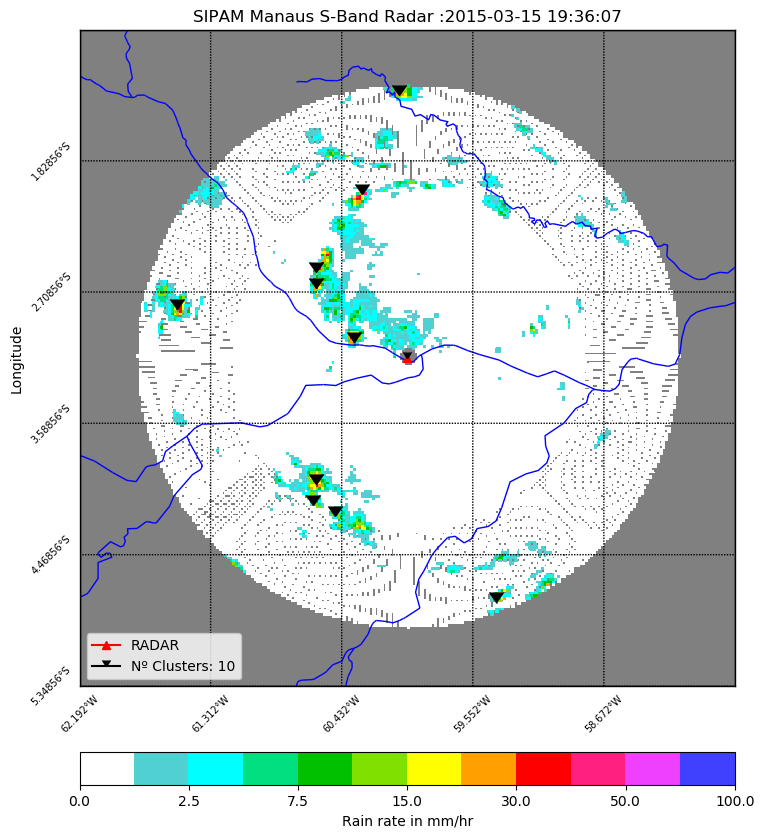

In [21]:
day = 20150315
plot(0,day)

In [20]:
import matplotlib.colors as mcolors
from mpl_toolkits.basemap import Basemap
from matplotlib import animation
from matplotlib import markers

def plot(frame,day):

    data = readData(day)
    proc = pre_processing(data[frame])
    clt = clust(proc)

    cdata = createData(day,frame,clt,data[frame])
    centers = centroidData(cdata)

    if centers is not None:
        c_lat = centers['LAT']
        c_lon = centers['LON']
        
        centroid = []
        for i in range(centers['N_Cluster'].max()):
            ct = centers.loc[centers['ID_CLUS'] == i ]
#             ct = ct.loc[ct['RAIN_FALL'] == ct['RAIN_FALL'].max()]
            centroid.append(ct) 
    else:
        centroid = ''
        
    file = path+str(day)+'/'+str(sorted(os.listdir(path+str(day)))[frame])
    xds = xr.open_dataset(file)
    date_time = xds.start_time.data
    date_time = pd.to_datetime(date_time)

    my_coords = [-3.148556, -59.992000]     ## RADAR T1 SIPAM COORDS
    zoom_scale = 2.2                        ## ZOOM SCALE

    bbox = [my_coords[0]-zoom_scale,my_coords[0]+zoom_scale,\
             my_coords[1]-zoom_scale,my_coords[1]+zoom_scale]


    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,10),dpi=100)
    label = 'Rain rate in ' + runit+ ''
    title = 'SIPAM Manaus S-Band Radar :' + str(date_time)

    # draw filled contours.
    clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
                 50, 70, 100]

    cmap_data = [(1.0, 1.0, 1.0),
                     (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
                     (0.0, 1.0, 1.0),
                     (0.0, 0.8784313797950745, 0.501960813999176),
                     (0.0, 0.7529411911964417, 0.0),
                     (0.501960813999176, 0.8784313797950745, 0.0),
                     (1.0, 1.0, 0.0),
                     (1.0, 0.6274510025978088, 0.0),
                     (1.0, 0.0, 0.0),
                     (1.0, 0.125490203499794, 0.501960813999176),
                     (0.9411764740943909, 0.250980406999588, 1.0),
                     (0.501960813999176, 0.125490203499794, 1.0),
                     (0.250980406999588, 0.250980406999588, 1.0)]

    cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
    norm = mcolors.BoundaryNorm(clevs, cmap.N)
    ax = axes

    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
                    llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

    ## PRECIPTACAO
    xi, yi = m(lon, lat)
    ## SIPAM RADAR
    xm, ym = m(my_coords[1],my_coords[0])
    radar = m.plot(xm,ym, marker='^',color='r', label='RADAR')

    for cent in range(len(centroid)):
        clat, clon, mm_f = centroid[cent]['LAT'].item(),centroid[cent]['LON'].item(),centroid[cent]['RAIN_FALL'].item()
        #clat, clon, mm_f = centroid[1]['LAT'].item(),centroid[1]['LON'].item(),centroid[1]['RAIN_FALL'].item()
        t3x,t3y = m(clon, clat)
        m.plot(t3x,t3y, marker=markers.CARETDOWN, markersize=10, color='k')
#         plt.annotate(str(mm_f)[0:5]+'mm/h', xy=(t3x,t3y),xytext=(t3x+12,t3y+12),rotation=45, size=10)

    m.plot(xm,ym, label='Nº Clusters: ' +str(len(centroid)),marker=markers.CARETDOWN, color='k')

    cs = m.pcolormesh(xi,yi,data[frame], cmap = cmap, norm = norm, ax=ax)

    # # # # Add Grid Lines
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0],rotation=45, size=(7))
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45, size=(7))
    m.drawmapboundary(fill_color='gray')

    m.readshapefile('./img/hidro/lineaire_1km', 'hidro10km', color='b', linewidth=1)
    # # # # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(label)

    # # # # # Add Title
    plt.title(title)
    plt.legend()
    plt.ylabel('Longitude', labelpad=40)
    plt.xlabel('Latitude', labelpad=60)

    plt.savefig('radar_image/'+ sorted(os.listdir(path+str(day)))[frame]+'.png')

    plt.show()

In [ ]:
## CREATE ALL FIGS
for i in range(len(frames)):
    plot(i,day)

### 3. Tracking

In [22]:
import glob
from scipy.spatial.distance import cdist

In [23]:
l = [pd.read_csv(filename) for filename in sorted(glob.glob("output/centroids/*.csv"))]
dados = pd.concat(l, axis=0, sort=False)
dados['DATETIME'] =  pd.to_datetime(dados['DATETIME'], format='%Y-%m-%d %H:%M:%S')
dados = dados.set_index('DATETIME')
dados.index = dados.index.map(lambda x: x.replace(second=0))

freqtime = pd.date_range(start=dados.index.min(), end=dados.index.max(), freq='12T')

time = []

for i in range(len(freqtime)):
    t = dados.loc[dados.index == freqtime[i]]
    time.append(t)

In [24]:
def calcDist(t1,t2):
    
    if len(t1) == 0 or len(t2) == 0:
        return None
    
    time1 = t1
    time2 = t2

    t1 = t1[['ID_CLUS','IND_X','IND_Y']]
    t1_data = t1.values.tolist()

    t2 = t2[['ID_CLUS','IND_X','IND_Y']]
    t2_data = t2.values.tolist()

    t1_ = pd.DataFrame(data=t1_data, columns=['T1', 'X', 'Y'])
    t2_ = pd.DataFrame(data=t2_data, columns=['T2', 'X', 'Y'])

    mask = cdist(t2_[['X', 'Y']].values, t1_[['X', 'Y']].values,'euclidean') < 5

    arr = []
    def zone(x):
        arr.append ( t1_[x].T1.values[0] if x.any() else np.nan)
        
    result = pd.DataFrame()
    
    np.apply_along_axis(zone, True, mask)
    result['T1'] = arr
    result['T2'] = t2_.T2.values

    
    result['START_TIME'] = t1.index[0]
    result['END_TIME'] = t2.index[0]
    result['X2'] = (t2.IND_X.values)
    result['Y2'] = (t2.IND_Y.values)
    result['LAT2'] = (time2.LAT.values)
    result['LON2'] = (time2.LON.values)

    x1,y1 = [],[]
    lat1,lon1 = [],[]
    lat2,lon2 = [],[]
    dist = []

    for i in range(len(arr)):
        a = time1.loc[time1.ID_CLUS == arr[i]]
        b = time2.loc[time2.ID_CLUS == arr[i]]
        x1.append(a['IND_X'].values)
        y1.append(a['IND_Y'].values)

        lat1.append(a['LAT'].values)
        lon1.append(a['LON'].values)

    result['X1']= x1
    result['Y1']= y1
    result['LAT1'] = lat1
    result['LON1'] = lon1

    result['X1'] = result['X1'].str[0]
    result['Y1'] = result['Y1'].str[0]
    result['LAT1'] = result['LAT1'].str[0]
    result['LON1'] = result['LON1'].str[0]
    
    result = result.sort_values('T1')
    result = result.dropna()
    result['T1'] = result['T1'].astype(int)
    result['X1'] = result['X1'].astype(int)
    result['Y1'] = result['Y1'].astype(int)
    
    dist,vel,rel = [],[],[]
    
    ## CALC DIST
    for i,row in result.iterrows():
        p1 = (str(row.LAT1)+','+str(row.LON1))
        p2 = (str(row.LAT2)+','+str(row.LON2))
        dist.append(geodesic(p1, p2).kilometers)
        d1 = (row.LAT1,row.LON1)
        d2 = (row.LAT2,row.LON2)
        rel.append(tRelation(d1,d2))
    
    result['DIST'] = dist
    result['REL'] = rel

    ## CALV VEL
    for i,row in result.iterrows():
        vel.append(row.DIST/0.2)
    result['VELM'] = vel
    result = result[['START_TIME','END_TIME','T1','T2','X1','Y1','X2','Y2','LAT1','LON1','LAT2','LON2','DIST','VELM','REL']]

    return result

In [25]:
track = pd.DataFrame()

aux = []

for i in range(len(time)):
    if len(time[i]) > 0:
        aux.append(i)
for i in range(len(aux)-1):
    track = track.append(calcDist(time[aux[i]],time[aux[i+1]]))

In [26]:
track.head()

,START_TIME,END_TIME,T1,T2,X1,Y1,X2,Y2,LAT1,LON1,LAT2,LON2,DIST,VELM,REL
1,2015-03-15 19:36:00,2015-03-15 19:48:00,0,1,181,103,182,100,-2.053316,-60.297604,-2.035335,-60.351532,6.320334,31.601670,SE
0,2015-03-15 19:36:00,2015-03-15 19:48:00,3,0,152,86,151,83,-2.574210,-60.603462,-2.592145,-60.657425,6.320269,31.601345,NE
7,2015-03-15 19:36:00,2015-03-15 19:48:00,5,7,138,34,136,31,-2.824800,-61.538975,-2.860649,-61.592990,7.195905,35.979527,NE
9,2015-03-15 19:36:00,2015-03-15 19:48:00,6,9,65,85,64,85,-4.137237,-60.622433,-4.155203,-60.622448,1.986682,9.933412,NE
3,2015-03-15 19:36:00,2015-03-15 19:48:00,8,3,61,93,61,91,-4.209187,-60.478374,-4.209167,-60.514404,4.000096,20.000478,SE


In [ ]:
track.to_csv('output/tracking/tracking.csv')

### 3. Statistics and Results

In [27]:
import glob
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [28]:
l = [pd.read_csv(filename) for filename in sorted(glob.glob("output/centroids/*.csv"))]
dados = pd.concat(l, axis=0, sort=False)
dados = dados.loc[:, ~dados.columns.str.contains('^Unnamed')]
dados['DATETIME'] =  pd.to_datetime(dados['DATETIME'], format='%Y-%m-%d %H:%M:%S')
dados = dados.set_index('DATETIME')

In [29]:
f = [pd.read_csv(filename) for filename in sorted(glob.glob("output/tracking/*.csv"))]
tr = pd.concat(f, axis=0, sort=False)
tr = tr.loc[:, ~tr.columns.str.contains('^Unnamed')]
tr['START_TIME'] =  pd.to_datetime(tr['START_TIME'], format='%Y-%m-%d %H:%M:%S')
tr['END_TIME'] =  pd.to_datetime(tr['END_TIME'], format='%Y-%m-%d %H:%M:%S')
tr = tr.set_index('START_TIME')

In [30]:
dados.head()

,N_Cluster,ID_CLUS,LAT,LON,DIST,IND_X,IND_Y,T_RELATION,RAIN_FALL,DBz
DATETIME,,,,,,,,,,
2014-01-03 15:48:11,5.0,0.0,-4.712206,-59.451252,183.039558,33.0,150.0,SE,41.290218,48.863855
2014-01-03 15:48:11,5.0,1.0,-4.460711,-60.478523,154.833679,47.0,93.0,SW,36.253693,47.959936
2014-01-03 15:48:11,5.0,2.0,-4.047174,-59.073467,142.436170,70.0,171.0,SE,33.759628,47.464662
2014-01-03 15:48:11,5.0,3.0,-3.921415,-59.073597,133.102530,77.0,171.0,SE,23.575794,44.969761
2014-01-03 15:48:11,5.0,4.0,-4.280689,-59.037186,164.080874,57.0,173.0,SE,22.211754,44.555626


In [31]:
tr.head()

,END_TIME,T1,T2,X1,Y1,X2,Y2,LAT1,LON1,LAT2,LON2,DIST,VELM,REL
START_TIME,,,,,,,,,,,,,,
2014-01-03 15:48:00,2014-01-03 16:00:00,0,0.0,33,150,32.0,146.0,-4.712206,-59.451252,-4.730213,-59.523340,8.241904,41.209518,NE
2014-01-03 15:48:00,2014-01-03 16:00:00,1,2.0,47,93,45.0,91.0,-4.460712,-60.478523,-4.496624,-60.514584,5.638058,28.190288,NE
2014-01-03 15:48:00,2014-01-03 16:00:00,2,1.0,70,171,67.0,169.0,-4.047174,-59.073467,-4.101104,-59.109432,7.177308,35.886538,NE
2014-01-03 15:48:00,2014-01-03 16:00:00,3,4.0,77,171,78.0,167.0,-3.921415,-59.073597,-3.903515,-59.145645,8.242960,41.214800,SE
2014-01-03 15:48:00,2014-01-03 16:00:00,4,6.0,57,173,61.0,171.0,-4.280689,-59.037186,-4.208863,-59.073290,8.896568,44.482842,SE


In [32]:
tidy_data2014 = dados['2014']
tidy_data2015 = dados['2015']
tidy_trac2014 = tr['2014']
tidy_trac2015 = tr['2015']

#### OCORRÊNCIAS DE CLUSTERS

In [33]:
NCluster = tidy_data2014.resample('min').mean()
NCluster = NCluster.dropna()
NCluster = NCluster.resample('M')[['N_Cluster']].sum()

NCluster5 = tidy_data2015.resample('min').mean()
NCluster5 = NCluster5.dropna()
NCluster5 = NCluster5.resample('M')[['N_Cluster']].sum()

cdf2014 = pd.DataFrame({'date':NCluster.index, 'clusters':NCluster.values.ravel()})
cdf2015 = pd.DataFrame({'date':NCluster5.index, 'clusters':NCluster5.values.ravel()})

dt = tidy_trac2014.index.month.unique()
dn = []
for month_idx in dt.values:
    dn.append(calendar.month_abbr[month_idx])

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dn, y=cdf2014['clusters'], name="2014",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dn, y=cdf2015['clusters'], name="2015",
                         line_color='dimgray'))


fig.update_layout(
    title=go.layout.Title(
        text="Ocorrências de Clusters para os anos de 2014 e 2015",
        xref="paper",
        xanchor = "auto",
        x=0,
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Número de clusters",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"
            )
        )
    )
)
fig.write_image("img/graficos/clus_num2014_2015.png")

<img src="img/graficos/clus_num2014_2015.png" align="center" alt="Drawing" style="width: 800px;">

In [40]:
VELOM14 = tidy_trac2014.resample('M')[['VELM']].mean()
DISTM14 = tidy_trac2014.resample('M')[['DIST']].mean()
VELOM15 = tidy_trac2015.resample('M')[['VELM']].mean()
DISTM15 = tidy_trac2015.resample('M')[['DIST']].mean()

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dn, y=VELOM14['VELM'], name="2014",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dn, y=VELOM15['VELM'], name="2015",
                         line_color='dimgray'))


fig.update_layout(
    title=go.layout.Title(
        text="Velocidade média dos clusters 2014 e 2015",
        xref="paper",
        xanchor = "auto",
        x=0,
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Velocidade média mensal em km/h",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"
            )
        )
    )
)
fig.write_image("img/graficos/ve_med_2014_2015.png")

<img src="img/graficos/ve_med_2014_2015.png" align="center" alt="Drawing" style="width: 800px;">

In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dn, y=DISTM14['DIST'], name="2014",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dn, y=DISTM15['DIST'], name="2015",
                         line_color='dimgray'))


fig.update_layout(
    title=go.layout.Title(
        text="Distância média percorreida de clusters individuais 2014 e 2015",
        xref="paper",
        xanchor = "auto",
        x=0,
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Distância média percorrida em metros",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"
            )
        )
    )
)
fig.write_image("img/graficos/dist_med_2014_2015.png")

<img src="img/graficos/dist_med_2014_2015.png" align="center" alt="Drawing" style="width: 800px;">

#### PRECIPITACAO OCORRENCIAS

In [43]:
NRain = tidy_data2014.resample('min').mean()
NRain = NRain.dropna()
NRain = NRain.resample('MS')[['RAIN_FALL']].mean()

NRain5 = tidy_data2015.resample('min').mean()
NRain5 = NRain5.dropna()
NRain5 = NRain5.resample('MS')[['RAIN_FALL']].mean()

rdf2014 = pd.DataFrame({'date':NRain.index, 'clusters':NRain.values.ravel()})
rdf2015 = pd.DataFrame({'date':NRain5.index, 'clusters':NRain5.values.ravel()})

In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dn, y=rdf2014['clusters'], name="2014",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dn, y=rdf2015['clusters'], name="2015",
                         line_color='dimgray'))


fig.update_layout(
    title=go.layout.Title(
        text="Precipitação média mensal de 2014 e 2015",
        xref="paper",
        xanchor = "auto",
        x=0,
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Precipitação média por clusters",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"
            )
        )
    )
)
fig.write_image("img/graficos/prec_med_2014_2015.png")

<img src="img/graficos/prec_med_2014_2015.png" align="center" alt="Drawing" style="width: 800px;">

### RELACOES DIRECIONAIS

In [46]:
an2014 = tidy_data2014.resample('Y')['T_RELATION'].value_counts()

df2014 = pd.DataFrame({'Relação':an2014.index.get_level_values('T_RELATION').values, 'Valores':an2014.values.ravel()})

fig = px.bar(df2014, x='Relação', y='Valores', color='Relação', labels='Relação')
fig.update_layout(title_text='Relações direcionais para o ano de 2014')
fig.write_image("img/graficos/all_rel_dir_2014.png")

<img src="img/graficos/all_rel_dir_2014.png" align="center" alt="Drawing" style="width: 600px;">

In [47]:
an2015 = tidy_data2015.resample('Y')['T_RELATION'].value_counts()

an2015 = pd.DataFrame({'Relação':an2015.index.get_level_values('T_RELATION').values, 'Valores':an2015.values.ravel()})

fig = px.bar(an2015, x='Relação', y='Valores', color='Relação', labels='Relação')
fig.update_layout(title_text='Relações direcionais para o ano de 2015')
fig.write_image("img/graficos/all_rel_dir_2015.png")

<img src="img/graficos/all_rel_dir_2015.png" align="center" alt="Drawing" style="width: 600px;">

In [51]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=df2014['Relação'],
    y=df2014['Valores'],
    name='2014',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=an2015['Relação'],
    y=an2015['Valores'],
    name='2015',
    marker_color='lightsalmon'
))

fig.update_layout(title_text='Relações direcionais para os anos 2015 2015', barmode='group')
fig.write_image("img/graficos/rel_dir_20142015.png")

<img src="img/graficos/rel_dir_20142015.png" align="center" alt="Drawing" style="width: 600px;">

In [52]:
men2014 = tidy_data2014.resample('MS')['T_RELATION'].value_counts()

m2014 = pd.DataFrame({'Data': men2014.index.get_level_values('DATETIME').values.ravel(),
                      'Relação':men2014.index.get_level_values('T_RELATION').values.ravel(),
                      'Valores':men2014.values.ravel()})

m2014['Data'] = pd.to_datetime(m2014['Data'])

fig = px.bar(m2014, x='Data', y='Valores', color='Relação', labels='Relação',barmode='group')
fig.update_layout(title_text='Relações direcionais para o ano de 2014', xaxis = go.layout.XAxis(
   title=go.layout.xaxis.Title(text="Ano 2014")))
fig.write_image("img/graficos/rel_dir_2014.png")

<img src="img/graficos/rel_dir_2014.png" align="center" alt="Drawing" style="width: 800px;">

In [53]:
men2015 = tidy_data2015.resample('MS')['T_RELATION'].value_counts()

m2015 = pd.DataFrame({'Data': men2015.index.get_level_values('DATETIME').values.ravel(),
                      'Relação':men2015.index.get_level_values('T_RELATION').values.ravel(),
                      'Valores':men2015.values.ravel()})

m2015['Data'] = pd.to_datetime(m2015['Data'])

fig = px.bar(m2015, x='Data', y='Valores', color='Relação', labels='Relação',barmode='group')
fig.update_layout(title_text='Relações direcionais para o ano de 2015', xaxis = go.layout.XAxis(
   title=go.layout.xaxis.Title(text="Ano 2015")))
fig.write_image("img/graficos/rel_dir_2015.png")

<img src="img/graficos/rel_dir_2015.png" align="center" alt="Drawing" style="width: 800px;">

### FORTRACC

In [54]:
import glob
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go

In [55]:
f = [pd.read_csv(filename, delimiter=r"\s+") for filename in sorted(glob.glob("output/fortracc/*.txt"))]
fortracc = pd.concat(f, axis=0, sort=False)

In [56]:
fortracc.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,N_Cluster,LON,LAT,IND_X,IND_Y,REFLECT,yyyyy_xx1,yyyyy_xx2,yyyyyyy_xx3,yyy_xx4,yyy_xx5,RIVER,CXE,PRECIPIT,VIL
0,2014.0,3.0,1.0,0.0,0.0,2.0,-60.7314,-1.7289,83.0,49.0,21.2031,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9477,0.1680
1,2014.0,3.0,1.0,0.0,0.0,2.0,-60.7914,-1.7489,80.0,50.0,20.9844,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9164,0.2786
2,2014.0,3.0,1.0,0.0,0.0,2.0,-60.7714,-1.7489,81.0,50.0,21.7500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0306,0.2494
3,2014.0,3.0,1.0,0.0,0.0,2.0,-60.7514,-1.7489,82.0,50.0,21.2188,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9499,0.2413
4,2014.0,3.0,1.0,0.0,0.0,2.0,-60.7314,-1.7489,83.0,50.0,21.4375,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.9824,0.1745


In [57]:
## FOR 2015
fdata = pd.DataFrame(columns=['YEAR','MONTH','DAY','HOUR','MINUTE','N_Cluster','REFLECT','PRECIPIT'])

fdata['YEAR'] = fortracc['YEAR'].astype('int16')
fdata['MONTH'] = fortracc['MONTH'].astype('int16')
fdata['DAY'] = fortracc['DAY'].astype('int16')
fdata['HOUR'] = fortracc['HOUR'].astype('int16')
fdata['MINUTE'] = fortracc['MINUTE'].astype('int16')
fdata['N_Cluster'] = fortracc['N_Cluster'].astype('int16')
fdata['REFLECT'] = fortracc['REFLECT'].astype('float32')
fdata['PRECIPIT'] = fortracc['PRECIPIT'].astype('float32')

fdata['DATETIME'] = fdata.apply(lambda row: datetime(
                              row['YEAR'], row['MONTH'], row['DAY'], row['HOUR'], row['MINUTE']), axis=1)

fdata = fdata.drop(columns=['YEAR','MONTH','DAY','HOUR','MINUTE'])
fdata = fdata.set_index('DATETIME')

tidy_fortracc = fdata.sort_values(by='DATETIME')

In [58]:
tidy_fortracc.head()

,N_Cluster,REFLECT,PRECIPIT
DATETIME,,,
2014-02-01,7,23.2656,1.9089
2014-02-01,10,22.1250,1.0917
2014-02-01,10,22.5312,1.1620
2014-02-01,10,25.2188,2.5921
2014-02-01,4,21.6719,1.4872


In [59]:
FCluster = tidy_fortracc.resample('min').mean()
FCluster = FCluster.dropna()
FCluster = FCluster.resample('M')[['N_Cluster']].sum()

FCluster2014 = pd.DataFrame({'date':FCluster.index, 'clusters':FCluster.values.ravel()})

In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dn, y=FCluster2014['clusters'], name="ForTraCC",
                         line_color='deepskyblue'))

fig.add_trace(go.Scatter(x=dn, y=cdf2014['clusters'], name="MS 2014",
                         line_color='dimgray'))

fig.add_trace(go.Scatter(x=dn, y=cdf2015['clusters'], name="MS 2015",
                         line_color='blueviolet'))


fig.update_layout(
    title=go.layout.Title(
        text="Média mensal do número de Clusters",
        xref="paper",
        xanchor = "auto",
        x=0,
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Número de Clusters",
            font=dict(
                family="Courier New, monospace",
                size=14,
                color="#7f7f7f"
            )
        )
    )
)
fig.write_image("img/graficos/fortracc.png")

<img src="img/graficos/fortracc.png" align="center" alt="Drawing" style="width: 800px;">

#### CONCLUSIONS

#### REFERENCES

* CHENG, Yizong. Mean shift, mode seeking, and clustering. IEEE transactions on pattern analysis and machine intelligence, v. 17, n. 8, p. 790-799, 1995.

* FRANK, Andrew U. Qualitative spatial reasoning: Cardinal directions as an example. International Journal of Geographical Information Science, v. 10, n. 3, p. 269-290, 1996.

* Mean Shift Clustering Overview by Matt Nedrich https://spin.atomicobject.com/2015/05/26/mean-shift-clustering/

* The NWS NEXRAD WSR88-D Radar: https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates

* PAPADIAS, Dimitris; THEODORIDIS, Yannis. Spatial relations, minimum bounding rectangles, and spatial data structures. International Journal of Geographical Information Science, v. 11, n. 2, p. 111-138, 1997.